In [1]:
import pandas as pd
from sqlalchemy import create_engine

In [5]:
#credentials for MYSQL
Engine = create_engine("mysql+mysqldb://username:"+'password'+"databasename"+"?charset=utf8") 

#message_body = text, dnc_intent = type of do not contact (Sms,Calls,SmsandCalls)
sql1="""select message_body, dnc_intent from sms_message sms where direction = 1 and dnc_intent not like 'None' """

#converting sql query into dataframe
sms = pd.read_sql(sql1,Engine)

In [7]:
sms.head()

,message_body,dnc_intent
0,Please text me.,Sms
1,Voy en camino.,Calls
2,Stop,Sms
3,Stop,Sms
4,Please text me.,Sms


In [8]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9170 entries, 0 to 9169
Data columns (total 2 columns):
message_body    9170 non-null object
dnc_intent      9170 non-null object
dtypes: object(2)
memory usage: 143.4+ KB


In [9]:
sms.describe()

,message_body,dnc_intent
count,9170,9170
unique,581,3
top,Stop,Sms
freq,4825,8715


In [10]:
sms['text length'] = sms['message_body'].apply(len) #length of text message

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

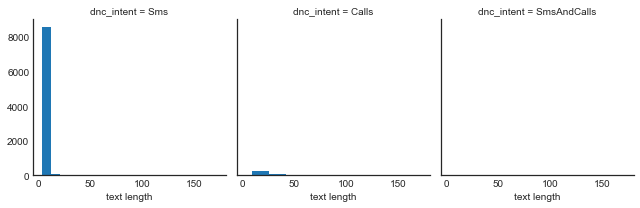

In [15]:
g = sns.FacetGrid(sms,col='dnc_intent')
g.map(plt.hist,'text length')

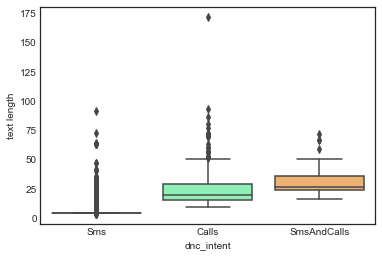

In [16]:
sns.boxplot(x='dnc_intent',y='text length',data=sms,palette='rainbow')

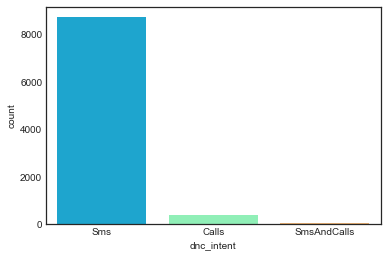

In [17]:
sns.countplot(x='dnc_intent',data=sms,palette='rainbow')

In [18]:
stars = sms.groupby('dnc_intent').mean()
stars

,text length
dnc_intent,
Calls,24.433090
Sms,4.432129
SmsAndCalls,31.863636


In [19]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer() #intial model that will help convert message body into something a statistical model can take in

In [20]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB() #model in use

In [21]:
from sklearn.feature_extraction.text import  TfidfTransformer

In [22]:
from sklearn.pipeline import Pipeline

In [23]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [26]:
from sklearn.model_selection import train_test_split
X = sms['message_body']
y = sms['dnc_intent']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

In [27]:
# May take some time
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [28]:
predictions = pipeline.predict(X_test)
prediction_prob = pipeline.predict_proba(X_test)

In [30]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[ 115    1    0]
 [  13 2608    0]
 [  13    0    1]]
             precision    recall  f1-score   support

      Calls       0.82      0.99      0.89       116
        Sms       1.00      1.00      1.00      2621
SmsAndCalls       1.00      0.07      0.13        14

avg / total       0.99      0.99      0.99      2751



In [32]:
#Getting prediction probability for different outcomes based on model

predictions_prob_call_list = []

x = 0 
for pred in prediction_prob:
    predictions_prob_call_list.append(prediction_prob[x][0])
    x = x + 1

predictions_prob_sms_list = []

x = 0 
for pred in prediction_prob:
    predictions_prob_sms_list.append(prediction_prob[x][1])
    x = x + 1

predictions_prob_both_list = []

x = 0 
for pred in prediction_prob:
    predictions_prob_both_list.append(prediction_prob[x][2])
    x = x + 1

In [33]:
dataset = pd.DataFrame({'predictions':predictions[:],'y_test':y_test[:]}) #combing predictions with actual outcome

In [34]:
dataset['predict_prob'] = predictions_prob_list #prediction probability

In [35]:
dataset = pd.merge(dataset,sms,how='left',left_index=True,right_index=True) #combining model data with prediction data + actual message

In [36]:
UnMatch_Data = dataset[dataset['predictions'] != dataset['y_test']] #Where predictions don't match actual

In [37]:
UnMatch_Data

,predictions,y_test,predict_prob,message_body,dnc_intent,text length
8489,Calls,SmsAndCalls,0.005707,Please delete me from your call list,SmsAndCalls,36
2400,Calls,SmsAndCalls,0.025628,Remove my number please,SmsAndCalls,24
2009,Calls,SmsAndCalls,0.005331,take me off your call list,SmsAndCalls,26
6114,Sms,Calls,0.998431,Stop callin,Calls,11
2760,Calls,Sms,0.080708,Just want the quotes sent to me .,Sms,34
5663,Calls,Sms,0.013823,Stop- do not text do not call!!!!!,Sms,34
914,Calls,Sms,0.191529,To stop last sender from sending you messages ...,Sms,63
3604,Calls,Sms,0.419632,Stop already have coverage,Sms,26
3683,Calls,Sms,0.175425,"Fwd:Message received, thanks! Reply STOP to op...",Sms,64
8594,Calls,SmsAndCalls,0.005047,Please do not contact me again,SmsAndCalls,30
